# SETUP
---

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
image_path = '/kaggle/input/multimodal-all-kcv/images'
tabular_path = '/kaggle/input/multimodal-all-kcv/full_dataset.csv'

label = 'Price'

random_state = 13

df = pd.read_csv(tabular_path)

# Data Preprocessing
---

## Fill NAN

In [3]:
# INTERGER
df.loc[df['Luas Bangunan'].isna(), 'Luas Bangunan'] = df['Luas Bangunan'].median()
df.loc[df['Luas Tanah'].isna(), 'Luas Tanah'] = df['Luas Tanah'].median()
df.loc[df['Daya Listrik'].isna(), 'Daya Listrik'] = df['Daya Listrik'].median()
df.loc[df['Tahun Dibangun'].isna(), 'Tahun Dibangun'] = df['Tahun Dibangun'].median()

df.loc[df['Kamar Tidur'].isna(), 'Kamar Tidur'] = df['Kamar Tidur'].mode()[0]
df.loc[df['Kamar Mandi'].isna(), 'Kamar Mandi'] = df['Kamar Mandi'].mode()[0]
df.loc[df['Carpots'].isna(), 'Carpots'] = df['Carpots'].mode()[0]
df.loc[df['Garasi'].isna(), 'Garasi'] = df['Garasi'].mode()[0]
df.loc[df['Sertifikat'].isna(), 'Sertifikat'] = df['Sertifikat'].mode()[0]
df.loc[df['Jumlah Lantai'].isna(), 'Jumlah Lantai'] = df['Jumlah Lantai'].mode()[0]

# OBJECT
df['Sertifikat'] = df['Sertifikat'].fillna(df['Sertifikat'].mode()[0])
df['Interior'] = df['Interior'].fillna(df['Interior'].mode()[0])
df['City'] = df['City'].fillna(df['City'].mode()[0])
df['City'] = df['City'].fillna(df['City'].mode()[0])



df['District'] = df['District'].fillna('Lain-lain')
df['Nama Perumahan'] = df['Nama Perumahan'].fillna('Lain-lain')
df['Address'] = df['Address'].fillna('Lain-lain')

df['Sertifikat'] = df['Sertifikat'].replace(['Hak Pakai', 'PPJB', 'Strata Title'], 'Lain-lain')

In [4]:
from scipy import stats

def remove_outliers(df, numerical_features, target_col='price_rp', 
                   iqr_quantiles=(0.25, 0.75), feature_threshold=1.5, 
                   price_threshold=3.0):
    """
    Robust outlier removal with configurable thresholds
    
    Parameters:
        numerical_features: List of numerical columns to process
        target_col: Target variable for special handling
        iqr_quantiles: Quantile range for IQR calculation
        feature_threshold: IQR multiplier for features
        price_threshold: IQR multiplier for target
    """
    clean_df = df.copy()
    Q1, Q3 = iqr_quantiles
    
    # Process numerical features
    for feature in numerical_features:
        if feature == target_col:
            continue
            
        q1 = clean_df[feature].quantile(Q1)
        q3 = clean_df[feature].quantile(Q3)
        iqr = q3 - q1
        
        lower = q1 - feature_threshold * iqr
        upper = q3 + feature_threshold * iqr
        
        clean_df = clean_df[(clean_df[feature] >= lower) & 
                          (clean_df[feature] <= upper)]
    return clean_df

# Specify numerical features for outlier removal
num_features = ['Luas Tanah', 'Luas Bangunan', 
        'Kamar Tidur', 'Kamar Mandi',
        'Carpots','Garasi', 
        'Daya Listrik', 'Jumlah Lantai']

# Remove outliers
print(f"Original shape: {df.shape}")

df = remove_outliers(
    df,
    numerical_features=num_features,
    iqr_quantiles=(0.05, 0.95), 
    feature_threshold=0.5,        
    price_threshold=3           
)

print(f", Cleaned shape: {df.shape}")

Original shape: (1923, 25)
, Cleaned shape: (1615, 25)


## IQR

In [9]:
# Compute Q1, Q3, and IQR
Q1 = df[label].quantile(0.25)
Q3 = df[label].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df[label] < lower_bound) | (df[label] > upper_bound)]
print(df.shape[0])

df = df[(df[label] >= lower_bound) & (df[label] <= upper_bound)]
print(df.shape[0])

1434
1406


<Axes: xlabel='Price'>

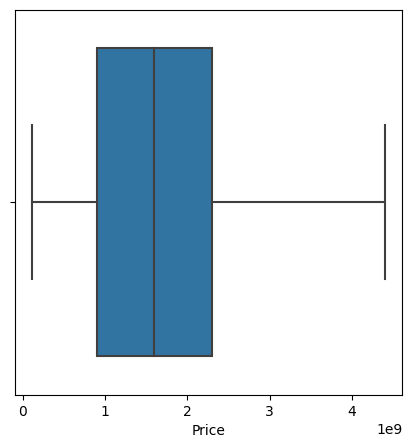

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5, 5))
sns.boxplot(df, x=label)

In [11]:
desc_df = df.describe().round().astype(int)
cols = desc_df.columns.drop(['ID'])

multi_cols = [(col, 'Train') for col in cols]
data = [[desc_df.loc[stat, col] for col in cols] for stat in desc_df.index]

combined_desc = pd.DataFrame(data, index=desc_df.index, columns=pd.MultiIndex.from_tuples(multi_cols))

display(combined_desc)  # Display only df statistics

,Price,Kamar Tidur,Kamar Mandi,Luas Tanah,Luas Bangunan,Carpots,Daya Listrik,Jumlah Lantai,Tahun Dibangun,Garasi,Latitude,Longitude
,Train,Train,Train,Train,Train,Train,Train,Train,Train,Train,Train,Train
count,1406,1406,1406,1406,1406,1406,1406,1406,1406,1406,1384,1384
mean,1689219879,3,2,132,140,1,2283,2,2020,1,-7,113
std,936997950,1,1,68,80,0,850,0,4,0,0,0
min,120000000,1,1,3,2,1,900,1,1989,1,-8,113
25%,900000000,3,1,88,80,1,2200,1,2020,1,-7,113
50%,1600000000,3,2,112,130,1,2200,2,2020,1,-7,113
75%,2300000000,4,3,160,180,1,2200,2,2020,1,-7,113
max,4400000000,9,7,690,600,2,5500,2,2025,1,-7,113


In [12]:
desc_df = df.describe(include="object")
cols = desc_df.columns.drop(['images_path'])

multi_cols = [(col, 'Train') for col in cols]
data = [[desc_df.loc[stat, col] for col in cols] for stat in desc_df.index]

combined_desc = pd.DataFrame(data, index=desc_df.index, columns=pd.MultiIndex.from_tuples(multi_cols))

display(combined_desc)  # Display only df statistics

,Title,Address,Nama Perumahan,Sertifikat,Interior,Tipe Properti,Tipe Iklan,Orientasi Bangunan,Province,City,District
,Train,Train,Train,Train,Train,Train,Train,Train,Train,Train,Train
count,1406,1406,1406,1406,1406,1378,1367,193,1406,1406,1406
unique,1357,106,147,3,3,1,1,13,1,3,29
top,RUMAH NEW 3 LANTAI DI DHARMAHUSADA INDAH BARAT,"Gedangan, Sidoarjo, Jawa Timur",Lain-lain,SHM,Unfurnished,Rumah,Sale,Utara,Jawa Timur,Surabaya,Gedangan
freq,9,162,1192,1347,1209,1378,1367,67,1406,677,166


In [23]:
print((df['Price']/160_000_000).describe())

count    1406.000000
mean       10.557624
std         5.856237
min         0.750000
25%         5.625000
50%        10.000000
75%        14.375000
max        27.500000
Name: Price, dtype: float64


In [24]:
scaled = np.log1p(df['Price']/160_000_000)
print(f"Scaled Statistics (Ratio=160M):\n"
      f"Min: {scaled.min():.2f}\n"
      f"25%: {np.percentile(scaled, 25):.2f}\n"
      f"Median: {np.median(scaled):.2f}\n"
      f"75%: {np.percentile(scaled, 75):.2f}\n"
      f"Max: {scaled.max():.2f}")

Scaled Statistics (Ratio=160M):
Min: 0.56
25%: 1.89
Median: 2.40
75%: 2.73
Max: 3.35


## Ordinal Encoder

In [25]:
def mean_encode_based_on_price(df, column):
    mean_prices = df.groupby(column)['Price'].mean() / 160_000_000
    return df[column].map(mean_prices)

# Apply mean encoding with normalization
df['Sertifikat'] = mean_encode_based_on_price(df, 'Sertifikat')
df['Interior'] = mean_encode_based_on_price(df, 'Interior')
df['City'] = mean_encode_based_on_price(df, 'City')
df['District'] = mean_encode_based_on_price(df, 'District')
df['Nama Perumahan'] = mean_encode_based_on_price(df, 'Nama Perumahan')
df['Address'] = mean_encode_based_on_price(df, 'Address')

## LOG

In [26]:
# Drop unnecessary columns
X = df.drop(columns=['ID', label, 'Orientasi Bangunan',
                     'Tipe Iklan', 'Province', 'Tipe Properti',
                     'Garasi', 'Latitude', 'Longitude', 'Carpots'])

num_cols = X.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.difference({'Sertifikat', 'Interior', 'City'})
X[num_cols] = np.log1p(X[num_cols])

# Apply log transformation to the target variable
#y = df[label]
#y = np.log1p(df[label])
y = np.log1p(df['Price'] / 160_000_000)

# Data Splitting
---

In [27]:
from sklearn.model_selection import train_test_split

# Create bins for continuous y
num_bins = 5
y_binned = pd.qcut(y, q=num_bins, labels=False, duplicates='drop')

# Stratified split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.1, 
    stratify=y_binned,
    random_state=random_state
)

In [28]:
X_train_tab = X_train.drop(columns=['images_path', 'Title'])
X_val_tab = X_val.drop(columns=['images_path', 'Title'])

X_train_img = X_train['images_path']
X_val_img = X_val['images_path']

X_train_text = X_train['Title']
X_val_text = X_val['Title']

# Text Feature Extractor
---

In [29]:
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.2 MB/s eta 0:00:00


In [30]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
from concurrent.futures import ThreadPoolExecutor

# Initialize once (not per call)
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()
stemmer = StemmerFactory().create_stemmer()
regex_pattern = re.compile(r'[^a-zA-Z0-9\s]')
numbers_pattern = re.compile(r'\d+')
spaces_pattern = re.compile(r'\s+')

from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

def clean_text_batch(texts):
    """Process a batch of texts together"""
    cleaned = [regex_pattern.sub('', text.lower()) for text in texts]
    cleaned = [stemmer.stem(stopword.remove(text)) for text in cleaned]
    return [spaces_pattern.sub(' ', numbers_pattern.sub('', text).strip()) for text in cleaned]

def parallel_clean_with_progress(text_series, batch_size=1000, workers=4):
    texts = text_series.tolist()
    results = []
    
    # Initialize progress bar
    with tqdm(total=len(texts), desc="Cleaning Text", unit="doc") as pbar:
        with ThreadPoolExecutor(max_workers=workers) as executor:
            # Submit all batches
            futures = {
                executor.submit(clean_text_batch, texts[i:i+batch_size]): i
                for i in range(0, len(texts), batch_size)
            }
            
            # Process as completed
            for future in as_completed(futures):
                results.extend(future.result())
                pbar.update(batch_size)  # Update progress
    
    return pd.Series(results, index=text_series.index)

# Usage with progress bars:
print("Cleaning training text...")
X_train_text_clean = parallel_clean_with_progress(X_train_text)

print("\nCleaning validation text...")
X_val_text_clean = parallel_clean_with_progress(X_val_text)

Cleaning training text...


Cleaning Text:   0%|          | 0/1265 [00:00<?, ?doc/s]


Cleaning validation text...


Cleaning Text:   0%|          | 0/141 [00:00<?, ?doc/s]

In [31]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Initialize IndoBERT
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
model_bert = AutoModel.from_pretrained("indolem/indobert-base-uncased").to('cuda' if torch.cuda.is_available() else 'cpu')

def get_bert_embeddings(text_series, batch_size=32):
    """Extract CLS token embeddings in batches"""
    embeddings = []
    for i in range(0, len(text_series), batch_size):
        batch = text_series.iloc[i:i+batch_size].tolist()
        inputs = tokenizer(batch, return_tensors='pt', 
                         padding=True, truncation=True, 
                         max_length=64,  # Adjust based on your title lengths
                         add_special_tokens=True).to(model_bert.device)
        
        with torch.no_grad():
            outputs = model_bert(**inputs)
        
        # Use mean pooling over all tokens (better than CLS for short texts)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(batch_embeddings)
    
    return np.vstack(embeddings)

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [32]:
# Extract features
X_train_bert = get_bert_embeddings(X_train_text_clean)
X_val_bert = get_bert_embeddings(X_val_text_clean)

bert_columns = [f'bert_{i}' for i in range(X_train_bert.shape[1])]

train_bert_df = pd.DataFrame(X_train_bert, columns=bert_columns, index=X_train_text_clean.index)
val_bert_df = pd.DataFrame(X_val_bert, columns=bert_columns, index=X_val_text_clean.index)

# Images Feature Extractor
---

In [33]:
from tqdm import tqdm
import torch
from transformers import AutoImageProcessor, ResNetModel, AutoModel
from PIL import Image
from sklearn.decomposition import PCA

# Load model
model_name = "facebook/dinov2-large"  
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/549 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-23): 24 x Dinov2Layer(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2SdpaAttention(
          (attention): Dinov2SdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
      

In [34]:
def extract_image_embeddings(image_paths):
    kaggle_path = '/kaggle/input/multimodal-all-kcv'

    embeddings = []

    for path in tqdm(image_paths):
        image_path = os.path.join(kaggle_path, path)
        image = Image.open(image_path).convert('RGB')
        inputs = image_processor(image, return_tensors="pt")

        # Move the input to the device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            # embedding = outputs.pooler_output.squeeze(-1).squeeze(-1).cpu().numpy() #Resnet50
            embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy() #ViT 

        # embeddings.append(embedding) #Resnet50
        embeddings.append(embedding.squeeze(0)) #ViT

    return np.vstack(embeddings)

img_train_embeddings = extract_image_embeddings(X_train_img)
img_val_embeddings = extract_image_embeddings(X_val_img)

train_columns = [f'img_emb_{i}' for i in range(img_train_embeddings.shape[1])]
val_columns = [f'img_emb_{i}' for i in range(img_val_embeddings.shape[1])]

train_image_df = pd.DataFrame(img_train_embeddings, columns=train_columns)
val_image_df = pd.DataFrame(img_val_embeddings, columns=val_columns)

 63%|██████▎   | 795/1265 [00:56<00:33, 14.02it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 141/141 [00:09<00:00, 14.41it/s]


# Intermediate Fusion
---

In [35]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
class MultimodalDataset(Dataset):
    def __init__(self, tabular_data, image_features, text_embeddings, labels):
        """
        Args:
            tabular_data: DataFrame or numpy array
            image_features: DataFrame or numpy array
            text_embeddings: DataFrame or numpy array
            labels: Series or numpy array
        """
        # Handle numpy arrays and DataFrames
        self.tabular_data = torch.as_tensor(
            tabular_data.values if hasattr(tabular_data, 'values') else tabular_data,
            dtype=torch.float32
        )
        self.image_features = torch.as_tensor(
            image_features.values if hasattr(image_features, 'values') else image_features,
            dtype=torch.float32
        )
        self.text_embeddings = torch.as_tensor(
            text_embeddings.values if hasattr(text_embeddings, 'values') else text_embeddings,
            dtype=torch.float32
        )
        self.labels = torch.as_tensor(labels.values, dtype=torch.float32) if labels is not None else None
        
        # Validate shapes
        self._validate_shapes()
        
    def _validate_shapes(self):
        assert len(self.tabular_data) == len(self.image_features) == len(self.text_embeddings), \
               "All modalities must have same length"
        if self.labels is not None:
            assert len(self.tabular_data) == len(self.labels), \
                   "Features and labels length mismatch"
    
    def __len__(self):
        return len(self.tabular_data)
    
    def __getitem__(self, idx):
        if self.labels is not None:
            return (
                self.tabular_data[idx], 
                self.image_features[idx], 
                self.text_embeddings[idx],
                self.labels[idx]
            )
        return (
            self.tabular_data[idx], 
            self.image_features[idx], 
            self.text_embeddings[idx]
        )
    
    @property
    def feature_dims(self):
        """Returns dimensions of each modality for model initialization"""
        return {
            'tabular': self.tabular_data.shape[1],
            'image': self.image_features.shape[1],
            'text': self.text_embeddings.shape[1]
        }

In [36]:
class RobustMultimodalModel(nn.Module):
    def __init__(self, tab_dim, img_dim, text_dim=768):
        super().__init__()
        
        # Increased unified dimension
        self.unified_dim = 512
        
        # Enhanced Tabular Branch
        self.tabular_branch = nn.Sequential(
            nn.Linear(tab_dim, 1024),
            nn.GELU(),
            nn.LayerNorm(1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Linear(512, self.unified_dim)
        )
        
        # Enhanced Image Branch
        self.image_branch = nn.Sequential(
            nn.Linear(img_dim, 256),
            nn.GELU(),
            nn.LayerNorm(256),
            nn.Dropout(0.2),
            nn.Linear(256, self.unified_dim),
            nn.LayerNorm(self.unified_dim)
        )
        
        # Enhanced Text Branch
        self.text_branch = nn.Sequential(
            nn.Linear(text_dim, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Dropout(0.3),
            nn.Linear(512, self.unified_dim),
            nn.LayerNorm(self.unified_dim)
        )

        # Improved Cross-Modal Attention
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=self.unified_dim,
            num_heads=16,
            dropout=0.1,
            batch_first=True
        )

        # Enhanced Fusion Gate
        self.fusion_gate = nn.Sequential(
            nn.Linear(self.unified_dim*3, 256),
            nn.GELU(),
            nn.LayerNorm(256),
            nn.Linear(256, 3),
            nn.Softmax(dim=-1)
        )

        # Deepened Predictor
        self.predictor = nn.Sequential(
            nn.Linear(self.unified_dim*3, 1024),
            nn.GELU(),
            nn.LayerNorm(1024),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Linear(512, 1)
        )

        # Learnable weights
        self.alpha = nn.Parameter(torch.ones(3))
        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                # Use 'leaky_relu' as closest supported alternative
                nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='leaky_relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.LayerNorm):
                nn.init.constant_(module.weight, 1.0)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.MultiheadAttention):
                nn.init.xavier_uniform_(module.in_proj_weight)
                nn.init.xavier_uniform_(module.out_proj.weight)
                if module.in_proj_bias is not None:
                    nn.init.constant_(module.in_proj_bias, 0.)
                    nn.init.constant_(module.out_proj.bias, 0.)

    def forward(self, tabular, image, text):
        # Process modalities
        tab_out = self.tabular_branch(tabular) * self.alpha[0]
        img_out = self.image_branch(image) * self.alpha[1]
        txt_out = self.text_branch(text) * self.alpha[2]

        # Cross-modal attention
        combined = torch.stack([tab_out, img_out, txt_out], dim=1)
        attn_out, _ = self.cross_attention(combined, combined, combined)
        
        # Adaptive fusion
        gate_weights = self.fusion_gate(attn_out.flatten(start_dim=1))
        fused = torch.cat([
            attn_out[:,0] * gate_weights[:,0].unsqueeze(-1),
            attn_out[:,1] * gate_weights[:,1].unsqueeze(-1), 
            attn_out[:,2] * gate_weights[:,2].unsqueeze(-1)
        ], dim=1)
        
        # Final prediction
        return self.predictor(fused) + 0.1*(tab_out.mean() + img_out.mean() + txt_out.mean())

# Training
---

In [37]:
# Create datasets
from sklearn.preprocessing import StandardScaler

# 1. Scale tabular data FIRST
scaler_tab = StandardScaler()
X_train_tab_scaled = scaler_tab.fit_transform(X_train_tab)
X_val_tab_scaled = scaler_tab.transform(X_val_tab)  # Use same scaler!

# 2. Scale image features (if not already normalized)
scaler_img = StandardScaler()
train_image_df_scaled = scaler_img.fit_transform(train_image_df)
val_image_df_scaled = scaler_img.transform(val_image_df)

# 3. BERT embeddings typically don't need scaling (already normalized)
# But if you must scale:
#scaler_text = StandardScaler()
#train_bert_df_scaled = scaler_text.fit_transform(train_bert_df)
#val_bert_df_scaled = scaler_text.transform(val_bert_df)

# 4. NOW create datasets with scaled data
train_dataset = MultimodalDataset(
    X_train_tab_scaled, 
    train_image_df_scaled,
    train_bert_df,  # or original train_bert_df
    y_train
)

val_dataset = MultimodalDataset(
    X_val_tab_scaled,
    val_image_df_scaled,
    val_bert_df,  # or original val_bert_df
    y_val
)

# The Training
---

In [38]:
# Create dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
tabular_dim = X_train_tab.shape[1]
image_dim = train_image_df.shape[1]
text_df = train_bert_df.shape[1]
model = RobustMultimodalModel(tabular_dim, image_dim,text_df)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Training loop
num_epochs = 300
best_val_rmse = float('inf')  # Proper initialization
patience = 100
counter = 0

In [39]:
import torch.nn.functional as F  # Import for functional API

# Loss function and optimizer
class CurriculumHuber(nn.Module):
    def __init__(self):
        super().__init__()
        self.delta = 1.0  # Starts focused on small errors
        
    def update(self, epoch):
        self.delta = min(2.0, 1.0 + epoch*0.01)  # Gradually accept larger errors
        
    def forward(self, pred, target):
        return F.huber_loss(pred, target, delta=self.delta)

criterion = CurriculumHuber()

optimizer = torch.optim.AdamW(
    [
        {"params": model.tabular_branch.parameters(), "lr": 3e-4},
        {"params": model.image_branch.parameters(), "lr": 3e-4},
        {"params": model.text_branch.parameters(), "lr": 1e-4},
        {"params": model.cross_attention.parameters(), "lr": 1e-3},
        {"params": model.fusion_gate.parameters(), "lr": 1e-3},
        {"params": model.predictor.parameters(), "lr": 1e-3},
    ],
    weight_decay=0.005,  # Reduced regularization
    betas=(0.95, 0.999),  # Smoother gradient updates
    eps=1e-7
)

# Initialize scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=2e-3,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=0.3,
    div_factor=25,
    final_div_factor=1e4
)

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import torch.nn.functional as F

# Initialize lists to track losses
train_losses = []
val_losses = []
best_epoch = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    # Training phase
    for batch_idx, (tabular, image, text, target) in enumerate(train_loader):
        tabular = tabular.to(device)
        image = image.to(device)
        text = text.to(device)
        target = target.to(device).unsqueeze(1)  # Add extra dimension
        
        optimizer.zero_grad()
        
        # Forward pass (single output now)
        pred = model(tabular, image, text)
        
        # Combined loss
        huber_loss = F.huber_loss(pred, target, delta=1.0)
        mae_loss = F.l1_loss(pred, target)
        loss = 0.7 * huber_loss + 0.3 * mae_loss  # Weighted combination
        
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update LR after each batch
        
        train_loss += loss.item()

    
         # Calculate average training loss
    avg_train_loss = train_loss/len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for m in model.modules():
            if isinstance(m, nn.BatchNorm1d):
                m.track_running_stats = False
    
    with torch.no_grad():
        for tabular, image, text, target in val_loader:
            tabular = tabular.to(device)
            image = image.to(device)
            text = text.to(device)
            target = target.to(device)
            
            pred = model(tabular, image, text)
            huber = F.huber_loss(pred, target.unsqueeze(1))
            mae = F.l1_loss(pred, target.unsqueeze(1))
            loss = 0.7 * huber + 0.3 * mae  # Match training
            
            val_loss += loss.item()
            

            
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    avg_val_loss = val_loss/len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Convert to original price scale
    all_preds = np.expm1(np.array(all_preds).flatten()) * 160_000_000
    all_targets = np.expm1(np.array(all_targets)) * 160_000_000
    
    # Calculate metrics
    val_rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    val_mae = mean_absolute_error(all_targets, all_preds)
    
    print(f'\nEpoch {epoch+1}:')
    print(f'Train Loss: {train_loss/len(train_loader):.4f}')
    print(f'Val Loss: {val_loss/len(val_loader):.4f}')
    print(f'Val RMSE: {val_rmse:,.2f}')
    #print(f'Val MAE: {val_mae:,.2f}')
    
    # Early stopping
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

print("\nTraining completed!")
print(f"Best Validation RMSE: {best_val_rmse:,.2f}")


Epoch 1:
Train Loss: 1.1666
Val Loss: 0.9113
Val RMSE: 10,559,375,441.08

Epoch 2:
Train Loss: 0.7865
Val Loss: 1.3238
Val RMSE: 16,237,949,247.96

Epoch 3:
Train Loss: 0.6312
Val Loss: 0.5266
Val RMSE: 4,614,270,382.58

Epoch 4:
Train Loss: 0.5690
Val Loss: 0.5695
Val RMSE: 5,878,487,336.14

Epoch 5:
Train Loss: 0.4934
Val Loss: 0.2589
Val RMSE: 1,970,476,734.29

Epoch 6:
Train Loss: 0.4131
Val Loss: 0.2854
Val RMSE: 2,201,323,179.24

Epoch 7:
Train Loss: 0.3457
Val Loss: 0.1738
Val RMSE: 1,210,178,742.13

Epoch 8:
Train Loss: 0.3000
Val Loss: 0.1979
Val RMSE: 1,235,148,998.69

Epoch 9:
Train Loss: 0.2637
Val Loss: 0.1397
Val RMSE: 857,412,793.89

Epoch 10:
Train Loss: 0.2140
Val Loss: 0.1147
Val RMSE: 671,100,855.81

Epoch 11:
Train Loss: 0.1822
Val Loss: 0.1088
Val RMSE: 713,215,652.58

Epoch 12:
Train Loss: 0.1576
Val Loss: 0.1093
Val RMSE: 756,758,867.67

Epoch 13:
Train Loss: 0.1363
Val Loss: 0.0936
Val RMSE: 620,674,258.83

Epoch 14:
Train Loss: 0.1293
Val Loss: 0.0853
Val RMSE

# Testing
---

In [41]:
print("\nTraining completed!")
print(f"Best Validation RMSE: {best_val_rmse:,.4f}")
print(f'at epoch {epoch}')


Training completed!
Best Validation RMSE: 382,071,052.9992
at epoch 225


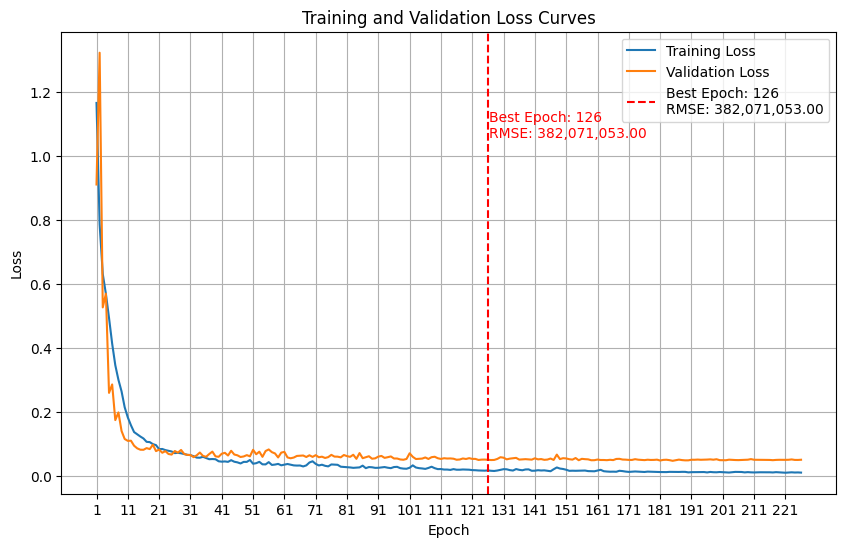

In [42]:
# After training completes
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axvline(x=best_epoch-1, color='r', linestyle='--', 
           label=f'Best Epoch: {best_epoch}\nRMSE: {best_val_rmse:,.2f}')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Add epoch numbers every 10 epochs
plt.xticks(np.arange(0, len(train_losses), step=10), 
          np.arange(1, len(train_losses)+1, step=10))

# Add text annotation for best epoch
plt.text(best_epoch-1 + 0.5, max(val_losses)*0.8,
        f'Best Epoch: {best_epoch}\nRMSE: {best_val_rmse:,.2f}',
        color='red', ha='left')

plt.show()

<ipython-input-43-b430f486ffa3>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Test Set Performance:
RMSE: 382,071,053.00
MAE: 258,660,611.09
R²: 0.8413


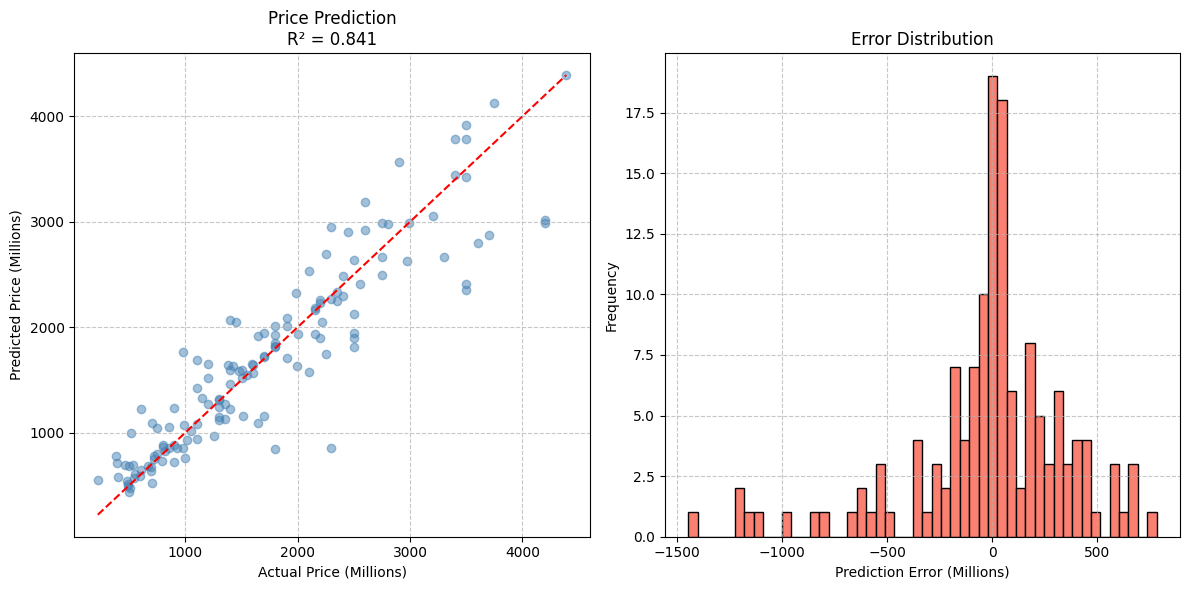


Additional Metrics:
Median Absolute Error: 176,622,619.63
Mean Absolute Percentage Error: 18.12%
Accuracy within 20%: 68.8%


In [43]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the best saved model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Store test predictions and targets
test_preds = []
test_targets = []

with torch.no_grad():
    for batch in val_loader:
        tabular, image, text, target = batch
        tabular = tabular.to(device)
        image = image.to(device)
        text = text.to(device)
        
        pred = model(tabular, image, text)
        test_preds.extend(pred.cpu().numpy())
        test_targets.extend(target.cpu().numpy())

# Convert to numpy arrays and scale back
test_preds = np.expm1(np.array(test_preds).flatten()) * 160_000_000
test_targets = np.expm1(np.array(test_targets)) * 160_000_000

# Calculate metrics
test_rmse = np.sqrt(mean_squared_error(test_targets, test_preds))
test_mae = mean_absolute_error(test_targets, test_preds)
test_r2 = r2_score(test_targets, test_preds)

print("\nTest Set Performance:")
print(f"RMSE: {test_rmse:,.2f}")
print(f"MAE: {test_mae:,.2f}")
print(f"R²: {test_r2:.4f}")

# Enhanced Visualization
plt.figure(figsize=(12, 6))

# Plot 1: Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(test_targets/1e6, test_preds/1e6, alpha=0.5, color='steelblue')
plt.plot([min(test_targets)/1e6, max(test_targets)/1e6], 
         [min(test_targets)/1e6, max(test_targets)/1e6], 'r--')
plt.xlabel('Actual Price (Millions)', fontsize=10)
plt.ylabel('Predicted Price (Millions)', fontsize=10)
plt.title(f'Price Prediction\nR² = {test_r2:.3f}', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Plot 2: Error distribution
plt.subplot(1, 2, 2)
errors = (test_preds - test_targets)/1e6
plt.hist(errors, bins=50, color='salmon', edgecolor='black')
plt.xlabel('Prediction Error (Millions)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.title('Error Distribution', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Additional metrics
percentage_errors = np.abs((test_preds - test_targets) / test_targets) * 100
print(f"\nAdditional Metrics:")
print(f"Median Absolute Error: {np.median(np.abs(test_preds - test_targets)):,.2f}")
print(f"Mean Absolute Percentage Error: {np.mean(percentage_errors):.2f}%")
print(f"Accuracy within 20%: {np.mean(percentage_errors < 20):.1%}")